# Libraries

In [15]:
from torcheeg import transforms
from torcheeg.datasets import DREAMERDataset
from torcheeg.datasets.constants.emotion_recognition.dreamer import DREAMER_CHANNEL_LOCATION_DICT

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import warnings

import torch
torch.multiprocessing.set_sharing_strategy('file_system')

head_outline = plt.imread('figures/head_outline_transparent.png')

# Constants

In [2]:
SEED_NUMBER = 1
NUM_WORKER = 8
overlap_percent = 0

overlap_name = f"{overlap_percent}_percent_overlap"
overlap = overlap_percent / 100

# Datasets

In [3]:
# dataloader without baseline removal
dreamer_without_baseline_removal = DREAMERDataset(
    io_path=f"dataset/processed_data/dreamer_de_grid_{overlap_name}_without_baseline_removal",
    mat_path="../../../../EEG/Dataset/DREAMER/DREAMER.mat",
    overlap=int(overlap * 128),  # 0, 32, 64, 96
    offline_transform=transforms.Compose(
        [
            transforms.BandDifferentialEntropy(),
            transforms.ToGrid(DREAMER_CHANNEL_LOCATION_DICT),
        ]
    ),
    online_transform=transforms.ToTensor(),
    label_transform=transforms.Compose(
        [transforms.Select(["subject_id", "valence"])]
    ),
    num_worker=NUM_WORKER,
)

[2024-11-06 12:09:15] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from dataset/processed_data/dreamer_de_grid_0_percent_overlap_without_baseline_removal.


In [4]:
# dataloader with baseline removal
dreamer_with_baseline_removal = DREAMERDataset(
    io_path=f"dataset/processed_data/dreamer_de_grid_{overlap_name}_with_baseline_removal",
    mat_path="../../../../EEG/Dataset/DREAMER/DREAMER.mat",
    overlap=int(overlap * 128),  # 0, 32, 64, 96
    offline_transform=transforms.Compose(
        [
            transforms.BandDifferentialEntropy(apply_to_baseline=True),
            transforms.ToGrid(DREAMER_CHANNEL_LOCATION_DICT, apply_to_baseline=True),
        ]
    ),
    online_transform=transforms.Compose(
        [
            transforms.BaselineRemoval(),
            transforms.ToTensor(),
        ]
    ),
    label_transform=transforms.Compose(
        [transforms.Select(["subject_id", "valence"])]
    ),
    num_worker=NUM_WORKER,
)

[2024-11-06 12:09:15] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from dataset/processed_data/dreamer_de_grid_0_percent_overlap_with_baseline_removal.


In [5]:
from dataset import prepare_dataloaders
grid_datasets = [dreamer_without_baseline_removal, dreamer_with_baseline_removal]
grid_trainloaders, grid_valloaders, grid_testloaders = prepare_dataloaders(grid_datasets, 1, 0.2, SEED_NUMBER, with_subject_id=True)

grid_dict = {
    'DREAMER Without Baseline Removal': grid_testloaders[0],
    'DREAMER With Baseline Removal': grid_testloaders[1],
}

# Visualization

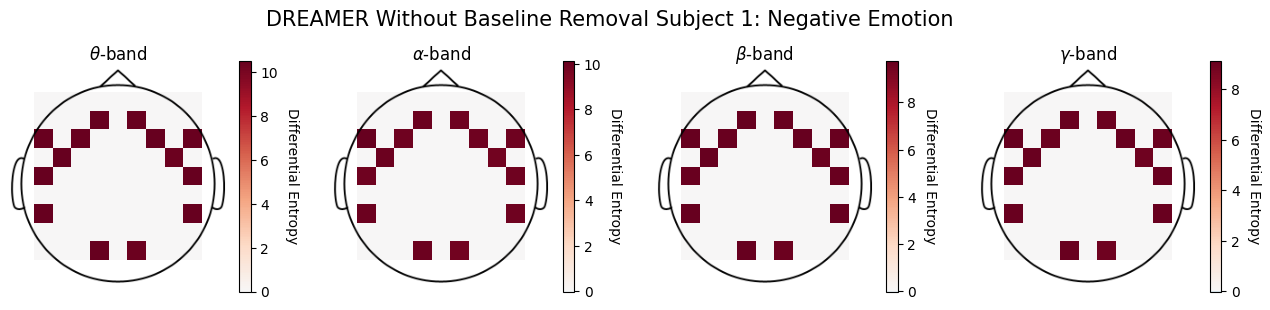

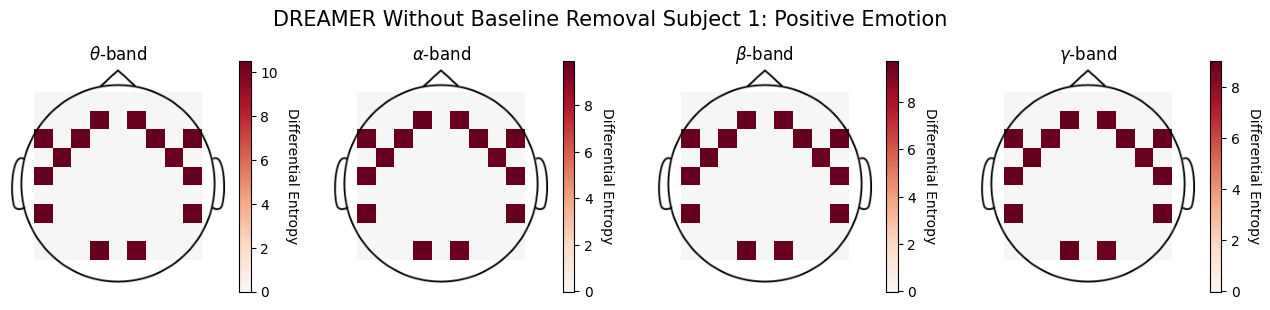

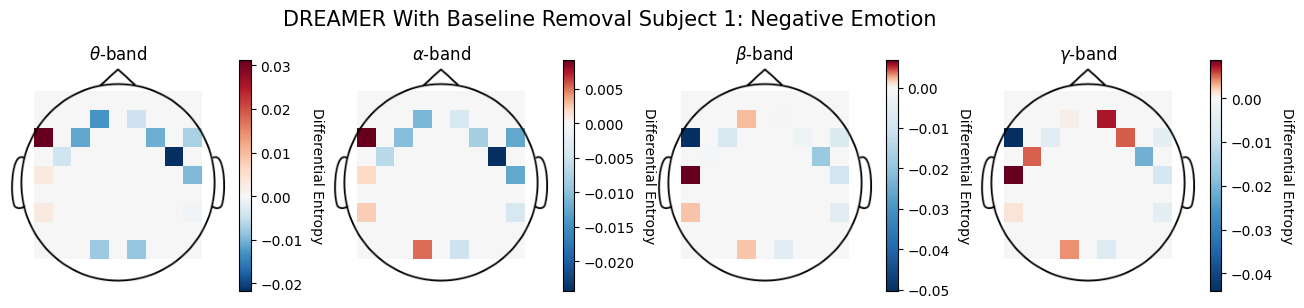

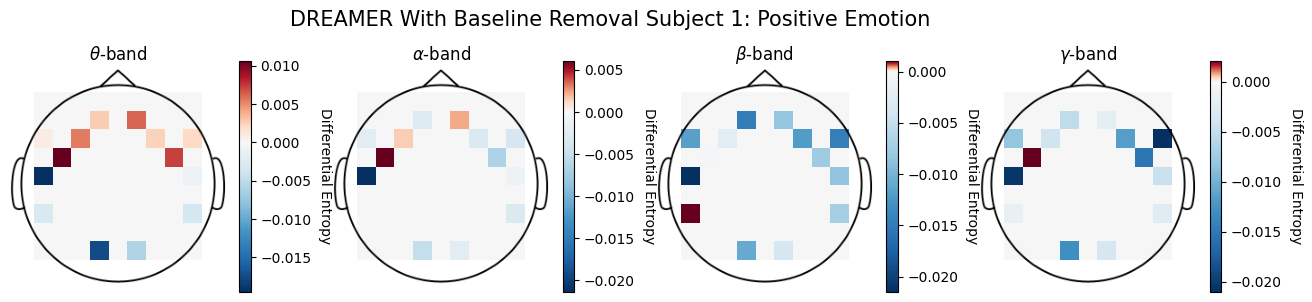

In [16]:
bands = ['$\\theta$-band', '$\\alpha$-band', '$\\beta$-band', '$\\gamma$-band']
warnings.filterwarnings("ignore", category=DeprecationWarning)

for dataset_name, loader in grid_dict.items():
    # Reset counts for each dataset
    positive_count = 0
    negative_count = 0
    
    for i, (X, y, subject_id) in enumerate(loader):
        subject_id = subject_id[0]
        if dataset_name == 'DEAP':
            subject_id = int(subject_id[1:3])
        elif dataset_name == 'DREAMER':
            subject_id = int(subject_id + 1)
        else:
            subject_id = int(subject_id)
            
        if subject_id != 1:
            continue
        
        emotion = 'Positive' if y[0] == 1 else 'Negative'
        
        # Check if the emotion count is already fulfilled
        if emotion == 'Positive' and positive_count >= 1:
            continue
        elif emotion == 'Negative' and negative_count >= 1:
            continue
        
        grid = X[0]
        fig, axes = plt.subplots(1, 4, figsize=(16, 3))
        for j, ax in enumerate(axes):
            vmin = grid[j].min()
            vmax = grid[j].max()
            vcenter = 0
            
            # Adjust vcenter to be within vmin and vmax range
            if vcenter < vmin:
                vcenter = vmin
            if vcenter > vmax:
                vcenter = vmax
            
            # Plot the background image
            ax.imshow(head_outline, aspect='auto', extent=[0, 9, 9, 0], alpha=1, zorder=3)
            
            # Plot the heatmap with a smaller extent
            norm = TwoSlopeNorm(vmin=vmin-1e-10, vcenter=vcenter, vmax=vmax+1e-10)
            h = sns.heatmap(grid[j], norm=norm, cmap="RdBu_r", cbar=False, ax=ax, alpha=0, zorder=2)
            ax.set_title(bands[j])
            ax.axis('off')
            
            # Shrink the heatmap to be smaller within the same background extent
            im = ax.imshow(grid[j], extent=[1, 8, 8, 1], alpha=1, zorder=1, cmap="RdBu_r", norm=norm)
            
            # Create the colorbar
            cbar = fig.colorbar(im, ax=ax)
            cbar.ax.set_yscale('linear')
            cbar.set_label('Differential Entropy', rotation=270, labelpad=15)
            
            
        plt.suptitle(f"{dataset_name} Subject {subject_id}: {emotion} Emotion", y=1.05, fontsize=15)
        plt.show()
        
        # Increment the corresponding counter
        if emotion == 'Positive':
            positive_count += 1
        elif emotion == 'Negative':
            negative_count += 1
        
        # Break if both positive and negative emotions have been visualized
        if positive_count >= 1 and negative_count >= 1:
            break